In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [4]:
df = pd.read_csv("../../../data/class_credit_score_encoded.csv", index_col="ID")

In [5]:
def handle_outliers(data: pd.DataFrame):
    data = data.copy(deep=True)
    numeric_vars = dslab.get_variable_types(data)["numeric"]
    summary = data[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=False)

        data[var + "_drop"] = data[var]
        data[var + "_drop"] = data[var].apply(
            lambda x: np.NaN if x > top or x < bottom else x
        )

        median = data[var].median()
        data[var + "_median"] = data[var].apply(
            lambda x: median if x > top or x < bottom else x
        )

        data[var + "_truncated"] = data[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    return data


0it [00:00, ?it/s]

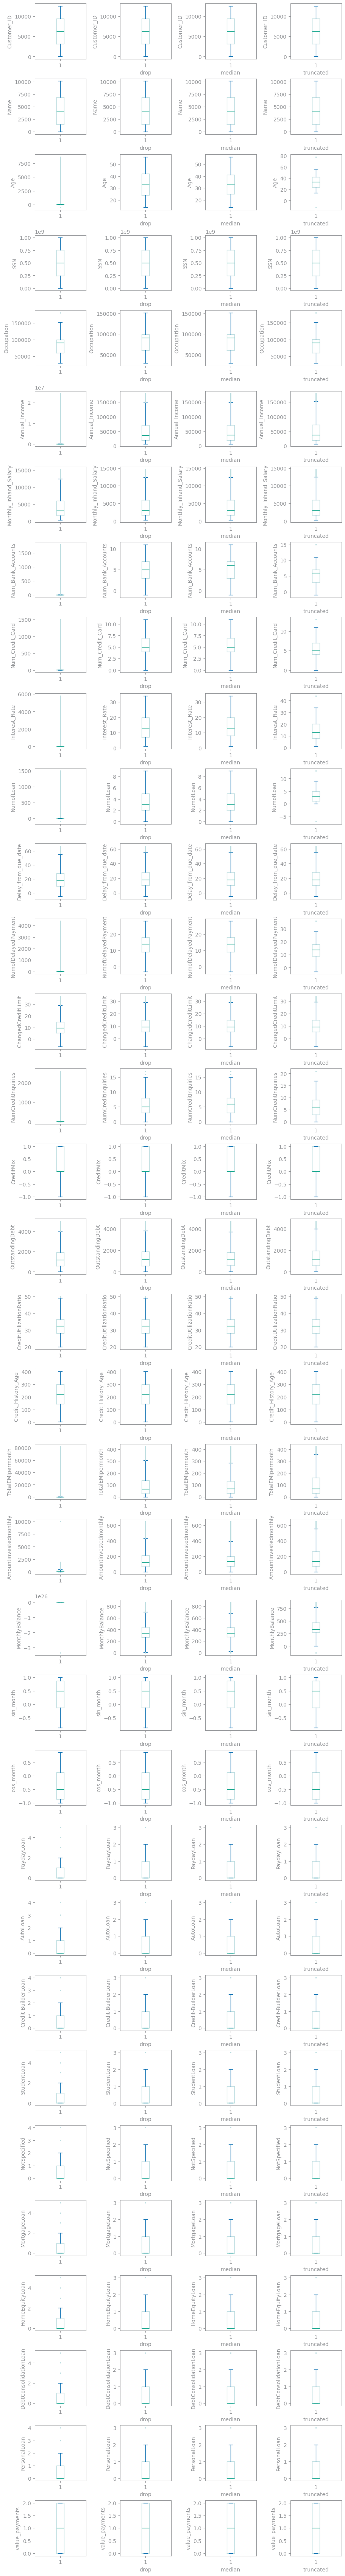

In [6]:
flierprops = dict(markersize=1)
numeric_vars = dslab.get_variable_types(df)["numeric"]
df_with_outliers = handle_outliers(df)
fig, axs = plt.subplots(ncols=4, nrows=len(numeric_vars), figsize=(9, 2 * len(numeric_vars)), constrained_layout=True)
for i, var in tqdm(enumerate(numeric_vars)):
    var_data = df_with_outliers[var]
    var_data = var_data[~np.isnan(var_data)]
    axs[i, 0].boxplot(var_data, flierprops=flierprops)
    axs[i, 0].set_ylabel(var)
    for j, approach in enumerate(["drop", "median", "truncated"]):
        var_data = df_with_outliers[var + "_" + approach]
        var_data = var_data[~np.isnan(var_data)]
        axs[i, j + 1].boxplot(var_data, flierprops=flierprops)
        axs[i, j + 1].set_ylabel(var)
        axs[i, j + 1].set_xlabel(f"{approach}")

plt.savefig(f"images/service_outlier_removal.png", bbox_inches='tight')

In [7]:
def remove_outliers(data: pd.DataFrame, strategy: str, std_based=False) -> pd.DataFrame:
    data = data.copy(deep=True)
    numeric_vars = dslab.get_variable_types(data)["numeric"]
    summary = data[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=std_based)

        if strategy == "drop":
            data[var] = data[var].apply(
                lambda x: np.NaN if x > top or x < bottom else x
            )
            data.dropna(subset=[var])
        elif strategy == "median":
            median = data[var].median()
            data[var] = data[var].apply(
                lambda x: median if x > top or x < bottom else x
            )
        elif strategy == "truncate":
            data[var] = data[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        else:
            raise ValueError(f"{strategy} not available")
    return data

df_removed = remove_outliers(df, strategy="drop")
df_removed.to_csv("../../../data/class_credit_score_outliers_removed.csv")


In [8]:
df_removed

,Customer_ID,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,AutoLoan,Credit-BuilderLoan,StudentLoan,NotSpecified,MortgageLoan,HomeEquityLoan,DebtConsolidationLoan,PersonalLoan,spent,value_payments
ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,49.0,81349.0,66960.0,65937.12,5465.760000,5.0,5.0,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1,1,49.0,81349.0,66960.0,65937.12,5465.760000,5.0,5.0,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1,49.0,81349.0,NaN,65937.12,5465.760000,5.0,5.0,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,1,1,49.0,81349.0,66960.0,65937.12,5465.760000,5.0,NaN,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5,1,1,49.0,81349.0,66960.0,65937.12,5465.760000,5.0,5.0,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,8493,7305,54.0,NaN,66960.0,20059.98,1523.665000,8.0,5.0,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
99997,2890,2736,48.0,NaN,99160.0,22620.79,1722.065833,6.0,2.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
99998,10432,3099,33.0,NaN,66960.0,59146.36,4908.863333,2.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
